<a href="https://colab.research.google.com/github/kor1999/ProjectCourse/blob/master/Project_Muhammad_Fahim(something_is_wrong).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing all libs

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from folder.plotcm import plot_confusion_matrix
import time
!pip install tensorboard

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


#Examples of images from dataset 


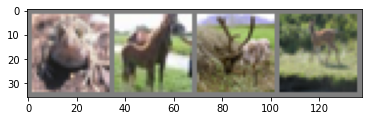

 frog horse  deer  deer


In [33]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = 5)
        #self.conv2_drop = nn.Dropout2d() 

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Save and load model

In [0]:
def save_model(net):
   PATH = './cifar_net60Pooling.pth' #Path for storying model
   torch.save(net.state_dict(), PATH)


def load_model():
  net = Net()
  net.load_state_dict(torch.load("./cifar_net60Pooling.pth"))
  return(net)

#Testing

In [0]:
def testing():
  dataiter = iter(trainloader)
  images, labels = dataiter.next()

  correct = 0
  total = 0
  with torch.no_grad():
      for data in trainloader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  
  return(100 * correct / total)

#Training model

In [0]:
def training():
  start_time = time.time()

  writer = SummaryWriter()

  i_batches = 0 # number of bathces for tensorBoard

  for epoch in range(60):  # loop over the dataset multiple times
      startEpochTime = time.time()

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          
              
          if i % 2000 == 1999:    # print every 2000 mini-batches
              #print(i + 1 % 12000)
              if i + 1 % 12000 == 12000:
                #print(i + 1)
                i_batches = i_batches + 1
                writer.add_scalar('Loss/train', running_loss / 2000, i_batches) # saving loss for graph in tensorBoard
              if i % 12000 == 11999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                writer.add_scalar("Accuracy on test set" , testing(), i_batches)
              running_loss = 0.0
      
      print((time.time() - startEpochTime) / 60)
      writer.add_scalar("Time of epoch (min)", (time.time() - startEpochTime) / 60, epoch) # saving  time of each epoch for comparing with different models

  print('Finished Training')
  print('Time ~ ' + str(round((time.time() - start_time) / 60) ) + ' min')

  save_model(net)
  return(writer)

# Run training and testing

In [0]:
#writer = training()

net = load_model()

In [49]:
testing()

Accuracy of the network on the 10000 test images: 82 %


82.024

#Confusion Matrix


In [0]:
def get_all_preds(net, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch
  

    preds = net(images)
    all_preds = torch.cat((all_preds, preds), dim = 0)

  return all_preds

with torch.no_grad():
  prediction_loader = torch.utils.data.DataLoader(trainset, batch_size = 2000)
  train_preds = get_all_preds(net, prediction_loader)

stacked = torch.stack((torch.tensor(trainset.targets), train_preds.argmax(dim = 1)),dim = 1)

cmt  = torch.zeros(10, 10, dtype = torch.int32)

for p in stacked:
  j, k = p.tolist()
  cmt[j, k] = cmt[j, k] + 1

Confusion matrix, without normalization
[[4163   67   93   88   76   11   22   46  289  145]
 [  38 4548    9   53   10    8   19    4   72  239]
 [ 218   24 3565  329  323  100  256   86   59   40]
 [  33   30  164 3871  204  275  232   78   34   79]
 [  51    7  129  334 4037   81  118  189   15   39]
 [  21   21  212  907  187 3173  157  220   29   73]
 [  15   37   60  231  126   28 4408   26   28   41]
 [  38    6   65  203  157   82   10 4389   10   40]
 [ 116  112   27   87   28    3   17   13 4380  217]
 [  51  225   17   77   22    7   35   25   63 4478]]


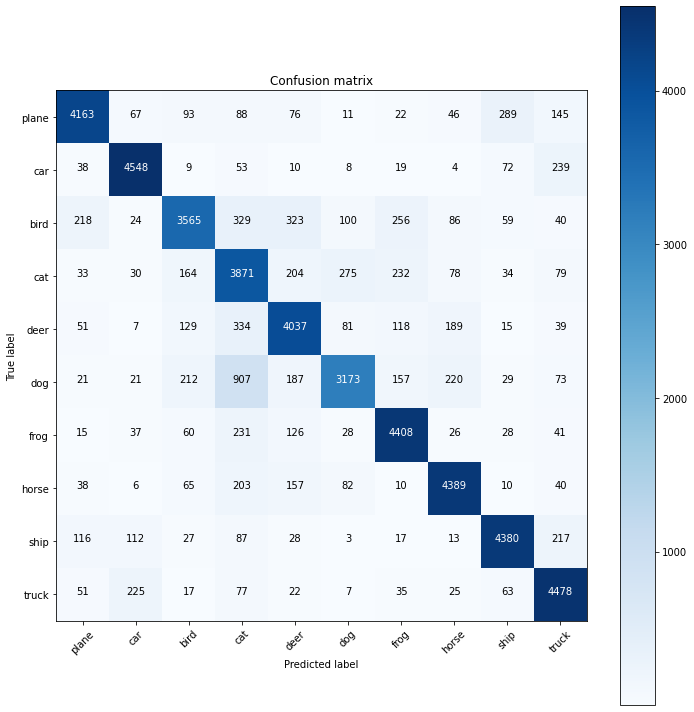

In [51]:
cm = confusion_matrix(torch.tensor(trainset.targets), train_preds.argmax(dim = 1))
names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, names)

# Precision, Recall and F-score

In [43]:

def precision(cm):
  TP_sum = 0
  FP_sum = 0
  for i in range(len(cm)):
    TP_sum += cm[i][i]
    FP_sum += 5000 - cm[i][i]
  return(TP_sum / (TP_sum + FP_sum))
print(precision(cm))

def recall(cm):
  TP_sum = 0
  FN_sum = 0
  for i in range(len(cm)):
    TP_sum += cm[i][i]
    for j in range(len(cm)):
      if(j != i):
        FN_sum += cm[j][i]
  return(TP_sum / (TP_sum + FN_sum))

print(recall(cm))

0.82024
0.82024


#TensorBoard 
(doesn't work if we load model, instead if training)

In [0]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(net, images)
writer.close()


In [0]:

%reload_ext tensorboard
%tensorboard --logdir=runs